<a href="https://colab.research.google.com/github/tusharsrivastav/subanalytics/blob/main/churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Importing the dependencies**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

**2. Data Loading and Understanding**

In [ ]:
# load teh csv data to a pandas dataframe
df = pd.read_csv("/content/saas_churn_dataset.csv")

In [ ]:
df.shape

(1000, 12)

In [ ]:
df.head()

,customer_id,signup_date,tenure_months,avg_session_duration,login_frequency,feature_usage_percentage,subscription_plan,contract_type,billing_frequency,is_auto_renew,num_support_tickets,churn
0,1,2023-04-13,3,8.85,22,90.58,Basic,Annual,Monthly,1,7,0
1,2,2023-12-15,33,40.21,6,69.98,Standard,Annual,Monthly,1,8,0
2,3,2023-09-28,6,19.91,17,80.86,Standard,Annual,Monthly,1,2,0
3,4,2023-04-17,10,37.60,23,50.89,Standard,Monthly,Yearly,1,1,0
4,5,2023-03-13,5,42.41,24,66.72,Basic,Monthly,Monthly,1,3,0


In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
df.head(2)

,customer_id,signup_date,tenure_months,avg_session_duration,login_frequency,feature_usage_percentage,subscription_plan,contract_type,billing_frequency,is_auto_renew,num_support_tickets,churn
0,1,2023-04-13,3,8.85,22,90.58,Basic,Annual,Monthly,1,7,0
1,2,2023-12-15,33,40.21,6,69.98,Standard,Annual,Monthly,1,8,0


In [ ]:
# df.info()
df.columns

Index(['customer_id', 'signup_date', 'tenure_months', 'avg_session_duration',
       'login_frequency', 'feature_usage_percentage', 'subscription_plan',
       'contract_type', 'billing_frequency', 'is_auto_renew',
       'num_support_tickets', 'churn'],
      dtype='object')

In [ ]:
# dropping customerID column as this is not required for modelling
df = df.drop(columns=["customer_id"])
df = df.drop(columns=["signup_date"])

In [ ]:
df.head(2)

,customer_id,signup_date,tenure_months,avg_session_duration,login_frequency,feature_usage_percentage,subscription_plan,contract_type,billing_frequency,is_auto_renew,num_support_tickets,churn
0,1,2023-04-13,3,8.85,22,90.58,Basic,Annual,Monthly,1,7,0
1,2,2023-12-15,33,40.21,6,69.98,Standard,Annual,Monthly,1,8,0


In [ ]:
df.columns

Index(['tenure_months', 'avg_session_duration', 'login_frequency',
       'feature_usage_percentage', 'subscription_plan', 'contract_type',
       'billing_frequency', 'is_auto_renew', 'num_support_tickets', 'churn'],
      dtype='object')

In [ ]:
# printing the unique values in all the columns

numerical_features_list = ['tenure_months', 'avg_session_duration', 'login_frequency',
       'feature_usage_percentage', 'num_support_tickets']

for col in df.columns:
  if col not in numerical_features_list:
    print(col, df[col].unique())
    print("-"*50)

subscription_plan ['Basic' 'Standard' 'Premium']
--------------------------------------------------
contract_type ['Annual' 'Monthly']
--------------------------------------------------
billing_frequency ['Monthly' 'Yearly' 'Quarterly']
--------------------------------------------------
is_auto_renew [1 0]
--------------------------------------------------
churn [0 1]
--------------------------------------------------


In [ ]:
print(df.isnull().sum())

tenure_months               0
avg_session_duration        0
login_frequency             0
feature_usage_percentage    0
subscription_plan           0
contract_type               0
billing_frequency           0
is_auto_renew               0
num_support_tickets         0
churn                       0
dtype: int64


In [ ]:
# checking the class distribution of target column
print(df["churn"].value_counts())

churn
0    771
1    229
Name: count, dtype: int64


**Insights:**
1. customer_id, signup_date removed as it is not required for modelling
2. No mmissing values in the dataset
3. Class imbalance identified in the target

**3. Exploratory Data Analysis (EDA)**

In [ ]:
df.shape

(1000, 10)

In [ ]:
df.columns

Index(['tenure_months', 'avg_session_duration', 'login_frequency',
       'feature_usage_percentage', 'subscription_plan', 'contract_type',
       'billing_frequency', 'is_auto_renew', 'num_support_tickets', 'churn'],
      dtype='object')

In [ ]:
df.head(2)

,tenure_months,avg_session_duration,login_frequency,feature_usage_percentage,subscription_plan,contract_type,billing_frequency,is_auto_renew,num_support_tickets,churn
0,3,8.85,22,90.58,Basic,Annual,Monthly,1,7,0
1,33,40.21,6,69.98,Standard,Annual,Monthly,1,8,0


In [ ]:
df.describe()

,tenure_months,avg_session_duration,login_frequency,feature_usage_percentage,is_auto_renew,num_support_tickets,churn
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000
mean,18.218000,31.985220,15.231000,54.324020,0.79200,4.67000,0.229000
std,10.184311,15.999649,8.406087,25.817878,0.40608,2.81834,0.420399
min,1.000000,5.010000,1.000000,10.060000,0.00000,0.00000,0.000000
25%,9.000000,17.585000,8.000000,31.595000,1.00000,2.00000,0.000000
50%,18.000000,31.860000,15.500000,53.935000,1.00000,5.00000,0.000000
75%,27.000000,45.922500,23.000000,76.762500,1.00000,7.00000,0.000000
max,35.000000,59.980000,29.000000,99.960000,1.00000,9.00000,1.000000


**Numerical Features - Analysis**

Understand the distribution of teh numerical features

In [ ]:
def plot_histogram(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  # calculate the mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

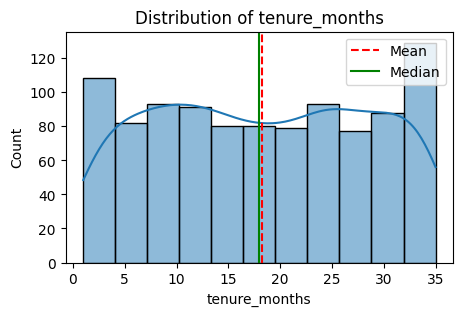

In [ ]:
plot_histogram(df, "tenure_months")

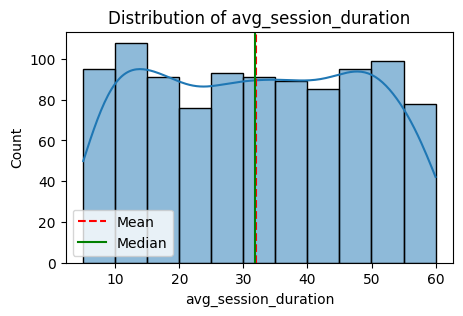

In [ ]:
plot_histogram(df, 'avg_session_duration')

**Box plot for numerical features**

In [ ]:
def plot_boxplot(df, column_name):

  plt.figure(figsize=(5, 3))
  sns.boxplot(y=df[column_name])
  plt.title(f"Box Plot of {column_name}")
  plt.ylabel(column_name)
  plt.show

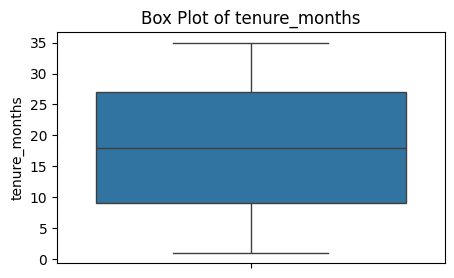

In [ ]:
plot_boxplot(df, "tenure_months")

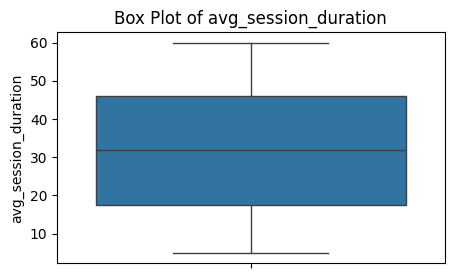

In [ ]:
plot_boxplot(df, "avg_session_duration")

**Correlation Heatmap for numerical columns**

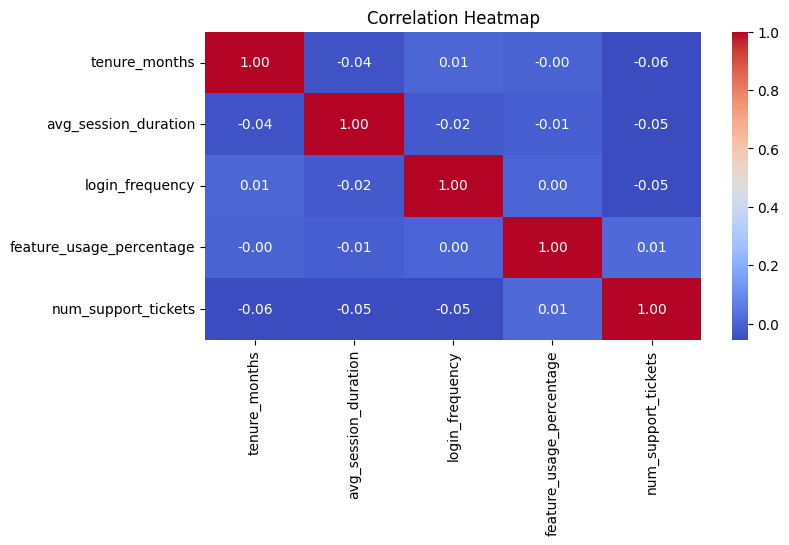

In [ ]:
# correlation matrix - heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df[['tenure_months', 'avg_session_duration', 'login_frequency',
       'feature_usage_percentage', 'num_support_tickets']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Categorical features - Analysis

In [ ]:
df.columns

Index(['tenure_months', 'avg_session_duration', 'login_frequency',
       'feature_usage_percentage', 'subscription_plan', 'contract_type',
       'billing_frequency', 'is_auto_renew', 'num_support_tickets', 'churn'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tenure_months             1000 non-null   int64  
 1   avg_session_duration      1000 non-null   float64
 2   login_frequency           1000 non-null   int64  
 3   feature_usage_percentage  1000 non-null   float64
 4   subscription_plan         1000 non-null   object 
 5   contract_type             1000 non-null   object 
 6   billing_frequency         1000 non-null   object 
 7   is_auto_renew             1000 non-null   int64  
 8   num_support_tickets       1000 non-null   int64  
 9   churn                     1000 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 78.2+ KB


Countplot for categorical columns

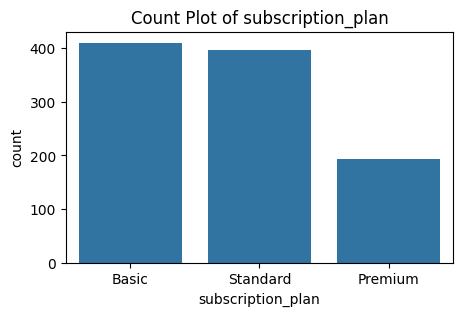

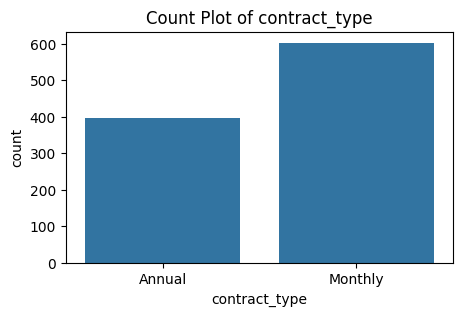

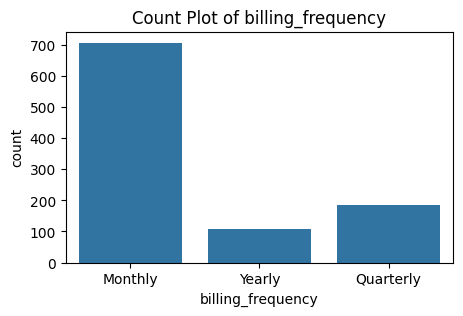

In [ ]:
object_cols = df.select_dtypes(include="object").columns.to_list()

object_cols = object_cols

for col in object_cols:
  plt.figure(figsize=(5, 3))
  sns.countplot(x=df[col])
  plt.title(f"Count Plot of {col}")
  plt.show()

**4. Data Preprocessing**

In [ ]:
df.head(3)

,tenure_months,avg_session_duration,login_frequency,feature_usage_percentage,subscription_plan,contract_type,billing_frequency,is_auto_renew,num_support_tickets,churn
0,3,8.85,22,90.58,Basic,Annual,Monthly,1,7,0
1,33,40.21,6,69.98,Standard,Annual,Monthly,1,8,0
2,6,19.91,17,80.86,Standard,Annual,Monthly,1,2,0


Label encoding of categorical fetaures

In [ ]:
# identifying columns with object data type
object_columns = df.select_dtypes(include="object").columns

In [ ]:
print(object_columns)

Index(['subscription_plan', 'contract_type', 'billing_frequency'], dtype='object')


In [ ]:
# initialize a dictionary to save the encoders
encoders = {}

# apply label encoding and store the encoders
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder


# save the encoders to a pickle file
with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)


In [ ]:
encoders

{'subscription_plan': LabelEncoder(),
 'contract_type': LabelEncoder(),
 'billing_frequency': LabelEncoder()}

In [ ]:
df.head()

,tenure_months,avg_session_duration,login_frequency,feature_usage_percentage,subscription_plan,contract_type,billing_frequency,is_auto_renew,num_support_tickets,churn
0,3,8.85,22,90.58,0,0,0,1,7,0
1,33,40.21,6,69.98,2,0,0,1,8,0
2,6,19.91,17,80.86,2,0,0,1,2,0
3,10,37.60,23,50.89,2,1,2,1,1,0
4,5,42.41,24,66.72,0,1,0,1,3,0


**Traianing and test data split**

In [ ]:
# splitting the features and target
X = df.drop(columns=["churn"])
y = df["churn"]

In [ ]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(y_train.shape)

(800,)


In [ ]:
print(y_train.value_counts())

churn
0    611
1    189
Name: count, dtype: int64


Synthetic Minority Oversampling Technique (SMOTE)

In [ ]:
smote = SMOTE(random_state=42)

In [ ]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
print(y_train_smote.shape)

(1222,)


In [ ]:
print(y_train_smote.value_counts())

churn
0    611
1    611
Name: count, dtype: int64


**5. Model Training**

Training with default hyperparameters

In [ ]:
# dictionary of models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

In [ ]:
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores):.2f}")
  print("-"*70)

print(cv_scores)

Training Decision Tree with default parameters
Decision Tree cross-validation accuracy: 0.71
----------------------------------------------------------------------
Training Random Forest with default parameters
Random Forest cross-validation accuracy: 0.78
----------------------------------------------------------------------
{'Decision Tree': array([0.67346939, 0.70204082, 0.73360656, 0.72131148, 0.72540984]), 'Random Forest': array([0.68163265, 0.8       , 0.79508197, 0.83606557, 0.81147541])}


Random Forest gives the highest accuracy compared to other models with default parameters

In [ ]:
rfc = RandomForestClassifier(random_state=42)

In [ ]:
rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

In [ ]:
print(y_test.value_counts())

churn
0    160
1     40
Name: count, dtype: int64


**6. Model Evaluation**

In [ ]:
# evaluate on test data
y_test_pred = rfc.predict(X_test)

print("Accuracy Score:\n", accuracy_score(y_test, y_test_pred))
print("\nConfsuion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

Accuracy Score:
 0.635

Confsuion Matrix:
 [[120  40]
 [ 33   7]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77       160
           1       0.15      0.17      0.16        40

    accuracy                           0.64       200
   macro avg       0.47      0.46      0.46       200
weighted avg       0.66      0.64      0.65       200



In [ ]:
# save the trained model as a pickle file
model_data = {"model": rfc, "features_names": X.columns.tolist()}


with open("customer_churn_model.pkl", "wb") as f:
  pickle.dump(model_data, f)

**7. Load the saved  model and  build a Predictive System**

In [ ]:
# load teh saved model and the feature names

with open("customer_churn_model.pkl", "rb") as f:
  model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["features_names"]

In [ ]:
print(loaded_model)

RandomForestClassifier(random_state=42)


In [ ]:
print(feature_names)

['tenure_months', 'avg_session_duration', 'login_frequency', 'feature_usage_percentage', 'subscription_plan', 'contract_type', 'billing_frequency', 'is_auto_renew', 'num_support_tickets']


In [ ]:
input_data = {
    'tenure_months': 12,
    'avg_session_duration': 45.3,  # in minutes
    'login_frequency': 20,  # logins per month
    'feature_usage_percentage': 75.6,  # usage of features in %
    'subscription_plan': 'Premium',
    'contract_type': 'Annual',
    'billing_frequency': 'Monthly',
    'is_auto_renew': True,
    'num_support_tickets': 2
}


input_data_df = pd.DataFrame([input_data])

with open("encoders.pkl", "rb") as f:
  encoders = pickle.load(f)


# encode categorical featires using teh saved encoders
for column, encoder in encoders.items():
  input_data_df[column] = encoder.transform(input_data_df[column])

# make a prediction
prediction = loaded_model.predict(input_data_df)
pred_prob = loaded_model.predict_proba(input_data_df)

print(prediction)

# results
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediciton Probability: {pred_prob}")

[1]
Prediction: Churn
Prediciton Probability: [[0.35 0.65]]


In [ ]:
encoders

{'gender': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder()}

**To do:**
1. Implement Hyperparameter Tuining
2. Try Model Selection
3. Try downsampling
4. Try to address teh overfitting
5. Try Startified k fold CV